In [1]:
import tensorflow as tf
import time
import os
import cv2
import numpy as np

997
float32


<IPython.core.display.Javascript object>


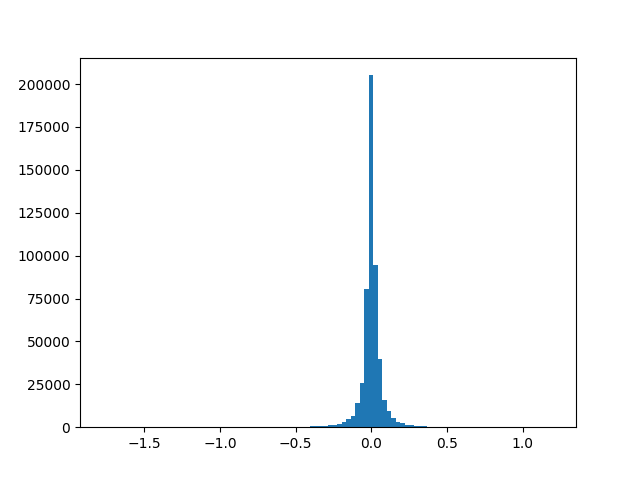

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   7.00000000e+00,   7.00000000e+00,
          4.00000000e+00,   1.80000000e+01,   1.40000000e+01,
          1.80000000e+01,   2.60000000e+01,   2.30000000e+01,
          3.50000000e+01,   4.80000000e+01,   6.40000000e+01,
          7.70000000e+01,   9.00000000e+01,   1.29000000e+02,
          1.41000000e+02,   2.06000000e+02,   2.52000000e+02,
          3.13000000e+02,   4.40000000e+02,   4.68000000e+02,
        

In [16]:
import threading
from matplotlib import pyplot as plt
%matplotlib notebook

class SampleInput:
    
    def __init__(self,path,cache_size=8,target_size=(256,256)):
        import glob
        self.file_list = []
        for single_path in path:
            self.file_list.extend(glob.glob("{}/*.png".format(single_path)))
            
        print len(self.file_list)
        self.cache = []
        self.cache_size = cache_size
        self.target_size = target_size
        self.read_task = threading.Thread(target=self.read_task)
        self.read_task.start()
        
    def read_task(self):
        sampled = np.random.choice(len(self.file_list),self.cache_size)
        for each in sampled:
            im = cv2.imread(self.file_list[each],-1)
            im = im[im.shape[0]/2:,im.shape[1]/3:2*im.shape[1]/3]
            im = cv2.resize(im,self.target_size)
            im = cv2.Laplacian(im,cv2.CV_32F)
            im = im[:,:,np.newaxis].astype(np.float32)
            im -= 0
            im /= 255
            self.cache.append(im)
    
    
    def sample(self):
        self.read_task.join()
        to_ret = np.array(self.cache)
        self.cache = []
        del self.read_task
        self.read_task = threading.Thread(target=self.read_task)
        self.read_task.start()
        return to_ret

    
S = SampleInput(["../data/2011_09_26/2011_09_26_drive_0018_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0056_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0093_sync/image_00/data/"])
R = S.sample()
print R.dtype
#plt.imshow(R[0,:,:,0])
plt.hist(R.flatten(),bins=100)

In [23]:
def NetBody(input_size):
    
    act = lambda x : tf.nn.leaky_relu(x,alpha=0.25)
    
    input_im = tf.placeholder(tf.float32,input_size,name="input_im")
    x = tf.layers.conv2d(input_im, 16, 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       , 32, 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       , 64, 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       ,128, 3 , 2 , 'same' ,activation=act)
    embbeding = tf.layers.conv2d(x       ,256, 3 , 2 , 'same' ,activation=tf.nn.tanh)
    
    x = tf.layers.conv2d_transpose(embbeding    ,256, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            ,128, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 64, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 32, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 16, 3 , 2 ,'same', activation=act)
    reconstructed = tf.layers.conv2d_transpose(x            ,  1, 1 , 1 ,'same', activation=tf.nn.tanh)
    return input_im , embbeding , reconstructed


batch_size = 8

if not os.path.exists("snapshots"):
    os.mkdir("snapshots")
    
S = SampleInput(["../data/2011_09_26/2011_09_26_drive_0018_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0056_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0093_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0013_sync/image_00/data/"],cache_size=batch_size)
with tf.Graph().as_default():
    input_im , embbeding , reconstructed = NetBody((batch_size,256,256,1))
    wloss   = tf.abs(input_im) > 0.02 
    reconstructed_loss = tf.losses.huber_loss(input_im,reconstructed,delta=0.05,weights=wloss)
    training_step      = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(reconstructed_loss)

    tf.summary.scalar("reconstructed_loss",reconstructed_loss)
    tf.summary.histogram("embbeding",embbeding)
    tf.summary.histogram("reconstructed",reconstructed)
    tf.summary.image("reconstructed_img",reconstructed,max_outputs=batch_size)
    tf.summary.image("input_img",input_im,max_outputs=batch_size)
    tf.summary.image("wloss",tf.to_float(wloss),max_outputs=batch_size)

    summary = tf.summary.merge_all()
    time_stamp = time.time()
    os.mkdir("logs/{}".format(time_stamp))
    train_writer = tf.summary.FileWriter("logs/{}".format(time_stamp))
    #train_restorer = tf.train.Saver([v for v in  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if not 'conv2d_transpose_6' in v.name])
    train_saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_saver.restore(sess,tf.train.latest_checkpoint('./snapshots/'))
        for idx in xrange(10000):
            input_sample = S.sample()
            _ , loss , reconstructed_img , summary_str = sess.run([training_step , reconstructed_loss , reconstructed, summary],
                                                              feed_dict={input_im : input_sample})
            
            print "iter {} loss {}".format(idx , loss)
            if idx % 10 == 0:
                train_writer.add_summary(summary_str,idx)
            if idx % 50 == 0:
                train_saver.save(sess,"snapshots/model.ckpt",global_step=idx)
                

1141
INFO:tensorflow:Restoring parameters from ./snapshots/model.ckpt-350
iter 0 loss 0.00120520510245
iter 1 loss 0.00109320017509
iter 2 loss 0.00146804063115
iter 3 loss 0.00135461275931
iter 4 loss 0.00130340829492
iter 5 loss 0.0013025192311
iter 6 loss 0.00099337217398
iter 7 loss 0.00115939776879
iter 8 loss 0.00108025898226
iter 9 loss 0.001244378509
iter 10 loss 0.00130730157252
iter 11 loss 0.001373705687
iter 12 loss 0.00143418589141
iter 13 loss 0.00109291763511
iter 14 loss 0.00111780012958
iter 15 loss 0.000966058054473
iter 16 loss 0.00145425309893
iter 17 loss 0.00116850307677
iter 18 loss 0.00122173805721
iter 19 loss 0.00151400256436
iter 20 loss 0.0012589385733
iter 21 loss 0.00104891997762
iter 22 loss 0.00113944686018
iter 23 loss 0.000865055830218
iter 24 loss 0.00158654234838
iter 25 loss 0.00120699964464
iter 26 loss 0.00119806570001
iter 27 loss 0.00131516112015
iter 28 loss 0.00119018869009
iter 29 loss 0.00101681612432
iter 30 loss 0.00103470159229
iter 31 lo

iter 265 loss 0.000952112372033
iter 266 loss 0.00100826390553
iter 267 loss 0.00074103748193
iter 268 loss 0.000885912799276
iter 269 loss 0.00089389400091
iter 270 loss 0.000771190447267
iter 271 loss 0.00131782551762
iter 272 loss 0.00122688175179
iter 273 loss 0.00114004919305
iter 274 loss 0.000711189582944
iter 275 loss 0.00149717356544
iter 276 loss 0.0012377203675
iter 277 loss 0.00104563566856
iter 278 loss 0.00139081676025
iter 279 loss 0.00129657494836
iter 280 loss 0.00122132606339
iter 281 loss 0.00118831300642
iter 282 loss 0.00123852083925
iter 283 loss 0.00120785657782
iter 284 loss 0.00129848287906
iter 285 loss 0.00131885160226
iter 286 loss 0.000974670576397
iter 287 loss 0.00103516201489
iter 288 loss 0.00109034671914
iter 289 loss 0.00125198799651
iter 290 loss 0.0013382906327
iter 291 loss 0.00129350600764
iter 292 loss 0.000671393994708
iter 293 loss 0.000999081064947
iter 294 loss 0.00119947188068
iter 295 loss 0.00113654846791
iter 296 loss 0.000958932447247
it

iter 529 loss 0.00110377778765
iter 530 loss 0.00116380956024
iter 531 loss 0.000964250066318
iter 532 loss 0.0012956863502
iter 533 loss 0.00074104568921
iter 534 loss 0.00110224820673
iter 535 loss 0.00149123487063
iter 536 loss 0.00124034646433
iter 537 loss 0.00141362205613
iter 538 loss 0.00120839616284
iter 539 loss 0.000899148115423
iter 540 loss 0.0012022688752
iter 541 loss 0.000935616553761
iter 542 loss 0.0011603400344
iter 543 loss 0.00108811142854
iter 544 loss 0.00131041172426
iter 545 loss 0.00115891743917
iter 546 loss 0.00109105720185
iter 547 loss 0.00106625363696
iter 548 loss 0.00106976984534
iter 549 loss 0.00103860697709
iter 550 loss 0.00114170578308
iter 551 loss 0.000930320587941
iter 552 loss 0.000923456100281
iter 553 loss 0.00126487284433
iter 554 loss 0.00141920277383
iter 555 loss 0.00130196800455
iter 556 loss 0.00130539515521
iter 557 loss 0.00133812567219
iter 558 loss 0.000970584340394
iter 559 loss 0.00113547604997
iter 560 loss 0.00110848725308
iter 

iter 792 loss 0.000805478892289
iter 793 loss 0.000980372657068
iter 794 loss 0.0012030270882
iter 795 loss 0.000974411494099
iter 796 loss 0.000783787923865
iter 797 loss 0.00116073014215
iter 798 loss 0.00107681378722
iter 799 loss 0.00112123647705
iter 800 loss 0.00107590039261
iter 801 loss 0.000964515202213
iter 802 loss 0.000781372073106
iter 803 loss 0.00119473028462
iter 804 loss 0.00117107422557
iter 805 loss 0.00124931160826
iter 806 loss 0.00121902755927
iter 807 loss 0.00105989619624
iter 808 loss 0.00134736194741
iter 809 loss 0.00128750305157
iter 810 loss 0.00104695709888
iter 811 loss 0.0013056647731
iter 812 loss 0.000825418333989
iter 813 loss 0.000859581225086
iter 814 loss 0.00133001268841
iter 815 loss 0.00123491021805
iter 816 loss 0.00117134756874
iter 817 loss 0.000855464488268
iter 818 loss 0.00113682390656
iter 819 loss 0.00123617064673
iter 820 loss 0.000957818003371
iter 821 loss 0.00104451854713
iter 822 loss 0.00105537602212
iter 823 loss 0.00128957442939


iter 1054 loss 0.0011229935335
iter 1055 loss 0.00125364132691
iter 1056 loss 0.000885633402504
iter 1057 loss 0.00093265355099
iter 1058 loss 0.00109770253766
iter 1059 loss 0.000919258454815
iter 1060 loss 0.000702312565409
iter 1061 loss 0.00131128507201
iter 1062 loss 0.000972734647803
iter 1063 loss 0.00103811267763
iter 1064 loss 0.00080483261263
iter 1065 loss 0.000888825510629
iter 1066 loss 0.00103210634552
iter 1067 loss 0.00105932261795
iter 1068 loss 0.00117397028953
iter 1069 loss 0.00119862530846
iter 1070 loss 0.00135096185841
iter 1071 loss 0.00102950562723
iter 1072 loss 0.00139215798117
iter 1073 loss 0.00124606862664
iter 1074 loss 0.00145725894254
iter 1075 loss 0.00108382594772
iter 1076 loss 0.00136962137185
iter 1077 loss 0.00115290563554
iter 1078 loss 0.0012116250582
iter 1079 loss 0.00126857252326
iter 1080 loss 0.00110270909499
iter 1081 loss 0.00112399610225
iter 1082 loss 0.000779312103987
iter 1083 loss 0.00104492192622
iter 1084 loss 0.00128449173644
iter

iter 1310 loss 0.00116596580483
iter 1311 loss 0.00101290259045
iter 1312 loss 0.00107617024332
iter 1313 loss 0.00118469935842
iter 1314 loss 0.000969786255155
iter 1315 loss 0.00151314865798
iter 1316 loss 0.000956915610004
iter 1317 loss 0.000817290390842
iter 1318 loss 0.00149579672143
iter 1319 loss 0.00106196163688
iter 1320 loss 0.00117227237206
iter 1321 loss 0.00105496135075
iter 1322 loss 0.00100351276342
iter 1323 loss 0.000702602847014
iter 1324 loss 0.00118767633103
iter 1325 loss 0.00114144640975
iter 1326 loss 0.00118871708401
iter 1327 loss 0.00116530247033
iter 1328 loss 0.00125859526452
iter 1329 loss 0.00113043107558
iter 1330 loss 0.00149617600255
iter 1331 loss 0.00103880756069
iter 1332 loss 0.000923413608689
iter 1333 loss 0.00104767153971
iter 1334 loss 0.00126093241852
iter 1335 loss 0.000774777727202
iter 1336 loss 0.00138824665919
iter 1337 loss 0.00135461427271
iter 1338 loss 0.0012765036663
iter 1339 loss 0.000880483363289
iter 1340 loss 0.00101675791666
it

iter 1565 loss 0.00126153999008
iter 1566 loss 0.00117194268387
iter 1567 loss 0.00122400210239
iter 1568 loss 0.00133849098347
iter 1569 loss 0.00131955253892
iter 1570 loss 0.00105920177884
iter 1571 loss 0.000891681236681
iter 1572 loss 0.00104627932888
iter 1573 loss 0.00123391801026
iter 1574 loss 0.00109840743244
iter 1575 loss 0.00118823419325
iter 1576 loss 0.0009146212833
iter 1577 loss 0.000796338892542
iter 1578 loss 0.000982915051281
iter 1579 loss 0.000908544519916
iter 1580 loss 0.00117442535702
iter 1581 loss 0.000908165471628
iter 1582 loss 0.00141240516677
iter 1583 loss 0.00101950089447
iter 1584 loss 0.00110341166146
iter 1585 loss 0.00108551571611
iter 1586 loss 0.000995547277853
iter 1587 loss 0.000994896516204
iter 1588 loss 0.0011744860094
iter 1589 loss 0.00111771537922
iter 1590 loss 0.00131718872581
iter 1591 loss 0.000984571757726
iter 1592 loss 0.00117029249668
iter 1593 loss 0.0009811114287
iter 1594 loss 0.00155651406385
iter 1595 loss 0.000958917662501
it

iter 1820 loss 0.0010046469979
iter 1821 loss 0.000780897622462
iter 1822 loss 0.00126302044373
iter 1823 loss 0.00115919474047
iter 1824 loss 0.00162656430621
iter 1825 loss 0.00103098619729
iter 1826 loss 0.00116868864279
iter 1827 loss 0.00119017215911
iter 1828 loss 0.00110259850044
iter 1829 loss 0.000728366081603
iter 1830 loss 0.000892829732038
iter 1831 loss 0.00127016939223
iter 1832 loss 0.000853988050949
iter 1833 loss 0.000867904745974
iter 1834 loss 0.00104601390194
iter 1835 loss 0.000968875887338
iter 1836 loss 0.000990981468931
iter 1837 loss 0.000956369331107
iter 1838 loss 0.000813184014987
iter 1839 loss 0.00112575455569
iter 1840 loss 0.00165210186969
iter 1841 loss 0.0010876590386
iter 1842 loss 0.00136562832631
iter 1843 loss 0.000880199717358
iter 1844 loss 0.000956801930442
iter 1845 loss 0.00113101943862
iter 1846 loss 0.00123576982878
iter 1847 loss 0.000799479603302
iter 1848 loss 0.000996883027256
iter 1849 loss 0.000850864918903
iter 1850 loss 0.00083796592

iter 2075 loss 0.00103465025313
iter 2076 loss 0.0008232005639
iter 2077 loss 0.000821973837446
iter 2078 loss 0.00128991913516
iter 2079 loss 0.00111577520147
iter 2080 loss 0.00116165110376
iter 2081 loss 0.000821772206109
iter 2082 loss 0.00113961286843
iter 2083 loss 0.00118307222147
iter 2084 loss 0.00106909510214
iter 2085 loss 0.00135639728978
iter 2086 loss 0.0011878706282
iter 2087 loss 0.00129389856011
iter 2088 loss 0.000823774142191
iter 2089 loss 0.000774847751018
iter 2090 loss 0.000814765749965
iter 2091 loss 0.00152191123925
iter 2092 loss 0.00104749470484
iter 2093 loss 0.00148695334792
iter 2094 loss 0.00130357767921
iter 2095 loss 0.00110594625585
iter 2096 loss 0.0012059037108
iter 2097 loss 0.00113292015158
iter 2098 loss 0.000849786621984
iter 2099 loss 0.00116236705799
iter 2100 loss 0.00103124009911
iter 2101 loss 0.000831657031085
iter 2102 loss 0.00124671403319
iter 2103 loss 0.00121638725977
iter 2104 loss 0.00111997767817
iter 2105 loss 0.00125628849491
iter

iter 2330 loss 0.00111211161129
iter 2331 loss 0.00119046051987
iter 2332 loss 0.00104654033203
iter 2333 loss 0.00126035627909
iter 2334 loss 0.00117016001604
iter 2335 loss 0.00111631699838
iter 2336 loss 0.0012987498194
iter 2337 loss 0.000929691246711
iter 2338 loss 0.00134339008946
iter 2339 loss 0.00108111137524
iter 2340 loss 0.000703180965502
iter 2341 loss 0.000736114627216
iter 2342 loss 0.00104227941483
iter 2343 loss 0.00101669935975
iter 2344 loss 0.00158109201584
iter 2345 loss 0.00111570663285
iter 2346 loss 0.00112988858018
iter 2347 loss 0.00106052507181
iter 2348 loss 0.00118030386511
iter 2349 loss 0.000938918499742
iter 2350 loss 0.0011191671947
iter 2351 loss 0.000848484225571
iter 2352 loss 0.00100734713487
iter 2353 loss 0.00113806512672
iter 2354 loss 0.0011102501303
iter 2355 loss 0.00138048152439
iter 2356 loss 0.000878305465449
iter 2357 loss 0.000826028292067
iter 2358 loss 0.00108769105282
iter 2359 loss 0.00119221804198
iter 2360 loss 0.00132105173543
iter

iter 2585 loss 0.000979082309641
iter 2586 loss 0.0011518553365
iter 2587 loss 0.00119966827333
iter 2588 loss 0.00111566390842
iter 2589 loss 0.000623080704827
iter 2590 loss 0.00110424822196
iter 2591 loss 0.000713264278602
iter 2592 loss 0.000905441236682
iter 2593 loss 0.000840374617837
iter 2594 loss 0.000782045652159
iter 2595 loss 0.00112322845962
iter 2596 loss 0.00137181102764
iter 2597 loss 0.00101359991822
iter 2598 loss 0.00130296859425
iter 2599 loss 0.000945748004597
iter 2600 loss 0.00120523909573
iter 2601 loss 0.00122723856475
iter 2602 loss 0.00145720131695
iter 2603 loss 0.00120936788153
iter 2604 loss 0.00127336219884
iter 2605 loss 0.000975888688117
iter 2606 loss 0.00110783032142
iter 2607 loss 0.000841082597617
iter 2608 loss 0.000806364987511
iter 2609 loss 0.000918401579838
iter 2610 loss 0.00101759086829
iter 2611 loss 0.00100391870365
iter 2612 loss 0.000891149044037
iter 2613 loss 0.00141795375384
iter 2614 loss 0.000980287091807
iter 2615 loss 0.00095243606

iter 2840 loss 0.00124643242452
iter 2841 loss 0.00106301950291
iter 2842 loss 0.00111465458758
iter 2843 loss 0.000736314279493
iter 2844 loss 0.00116106914356
iter 2845 loss 0.000635394710116
iter 2846 loss 0.00111299194396
iter 2847 loss 0.00107116647996
iter 2848 loss 0.00135501392651
iter 2849 loss 0.00103589496575
iter 2850 loss 0.00109444931149
iter 2851 loss 0.000975360861048
iter 2852 loss 0.00122149917297
iter 2853 loss 0.00116789608728
iter 2854 loss 0.00117965077516
iter 2855 loss 0.00139285088517
iter 2856 loss 0.00113662634976
iter 2857 loss 0.000925454252865
iter 2858 loss 0.00114647659939
iter 2859 loss 0.00114399299491
iter 2860 loss 0.000724477751646
iter 2861 loss 0.00120236072689
iter 2862 loss 0.00122592039406
iter 2863 loss 0.000572892837226
iter 2864 loss 0.00128756649792
iter 2865 loss 0.000777816050686
iter 2866 loss 0.00124246953055
iter 2867 loss 0.000932693830691
iter 2868 loss 0.00122003653087
iter 2869 loss 0.000831826939248
iter 2870 loss 0.00101119745523

iter 3095 loss 0.000910214905161
iter 3096 loss 0.00137036689557
iter 3097 loss 0.00121974060312
iter 3098 loss 0.00103543966543
iter 3099 loss 0.00128784205299
iter 3100 loss 0.00119956000708
iter 3101 loss 0.00111842388287
iter 3102 loss 0.00107311701868
iter 3103 loss 0.00137124187313
iter 3104 loss 0.00103673350532
iter 3105 loss 0.00079131743405
iter 3106 loss 0.00130616559181
iter 3107 loss 0.00120533816516
iter 3108 loss 0.00127017765772
iter 3109 loss 0.00141245499253
iter 3110 loss 0.00108652585186
iter 3111 loss 0.00101089000236
iter 3112 loss 0.00115709158126
iter 3113 loss 0.00106826401316
iter 3114 loss 0.00145799305756
iter 3115 loss 0.00109335104935
iter 3116 loss 0.00111478380859
iter 3117 loss 0.00116999656893
iter 3118 loss 0.00108848209493
iter 3119 loss 0.001010596985
iter 3120 loss 0.00111513899174
iter 3121 loss 0.00100774737075
iter 3122 loss 0.00093659030972
iter 3123 loss 0.00103552651126
iter 3124 loss 0.00112589995842
iter 3125 loss 0.000814020459075
iter 312

iter 3350 loss 0.00120781885926
iter 3351 loss 0.00100474723149
iter 3352 loss 0.00115360296331
iter 3353 loss 0.000941516249441
iter 3354 loss 0.000841617584229
iter 3355 loss 0.00103195221163
iter 3356 loss 0.00112748274114
iter 3357 loss 0.00126867380459
iter 3358 loss 0.00154752726667
iter 3359 loss 0.000797536515165
iter 3360 loss 0.00113541597966
iter 3361 loss 0.000933563977014
iter 3362 loss 0.00072796526365
iter 3363 loss 0.00105078949127
iter 3364 loss 0.000715045491233
iter 3365 loss 0.00124617514666
iter 3366 loss 0.000610452902038
iter 3367 loss 0.00112507434096
iter 3368 loss 0.000910172471777
iter 3369 loss 0.00107191689312
iter 3370 loss 0.00117915053852
iter 3371 loss 0.00106749567203
iter 3372 loss 0.00115957087837
iter 3373 loss 0.00124187325127
iter 3374 loss 0.00106361042708
iter 3375 loss 0.000952586415224
iter 3376 loss 0.00106702093035
iter 3377 loss 0.00102008669637
iter 3378 loss 0.00134670059197
iter 3379 loss 0.00109186978079
iter 3380 loss 0.00159176730085


iter 3605 loss 0.00130494288169
iter 3606 loss 0.00110435520764
iter 3607 loss 0.00093642208958
iter 3608 loss 0.00106652360409
iter 3609 loss 0.00112942385022
iter 3610 loss 0.000815024308395
iter 3611 loss 0.0010681101121
iter 3612 loss 0.00119785673451
iter 3613 loss 0.000888796406798
iter 3614 loss 0.00140070426278
iter 3615 loss 0.00126242858823
iter 3616 loss 0.00107738794759
iter 3617 loss 0.000879857863765
iter 3618 loss 0.000965848914348
iter 3619 loss 0.000800897250883
iter 3620 loss 0.001196523197
iter 3621 loss 0.00111410254613
iter 3622 loss 0.0012774587376
iter 3623 loss 0.00103270250838
iter 3624 loss 0.00105636974331
iter 3625 loss 0.00104015076067
iter 3626 loss 0.000940710131545
iter 3627 loss 0.00104855024256
iter 3628 loss 0.00111582130194
iter 3629 loss 0.00113679561764
iter 3630 loss 0.00102242361754
iter 3631 loss 0.0012012438383
iter 3632 loss 0.00111233768985
iter 3633 loss 0.000968296546489
iter 3634 loss 0.00132822792511
iter 3635 loss 0.00112186709885
iter 3

iter 3860 loss 0.000950643967371
iter 3861 loss 0.00106762116775
iter 3862 loss 0.00132788612973
iter 3863 loss 0.000779779453296
iter 3864 loss 0.000956871197559
iter 3865 loss 0.0010139165679
iter 3866 loss 0.00127892033197
iter 3867 loss 0.0013619796373
iter 3868 loss 0.00104794430081
iter 3869 loss 0.00117264385335
iter 3870 loss 0.00129982468206
iter 3871 loss 0.00125305471011
iter 3872 loss 0.00107418373227
iter 3873 loss 0.00152461894322
iter 3874 loss 0.000882269698195
iter 3875 loss 0.000908672227524
iter 3876 loss 0.00107022619341
iter 3877 loss 0.0013063828228
iter 3878 loss 0.000800826703198
iter 3879 loss 0.000919173646253
iter 3880 loss 0.000749024446122
iter 3881 loss 0.000933070667088
iter 3882 loss 0.00101092259865
iter 3883 loss 0.00096943351673
iter 3884 loss 0.00100803677924
iter 3885 loss 0.000932096096221
iter 3886 loss 0.00151465414092
iter 3887 loss 0.000706011604052
iter 3888 loss 0.0012385440059
iter 3889 loss 0.00123872829136
iter 3890 loss 0.00116100825835
i

iter 4114 loss 0.0010810358217
iter 4115 loss 0.00117551139556
iter 4116 loss 0.00131741620135
iter 4117 loss 0.00112595665269
iter 4118 loss 0.0010273528751
iter 4119 loss 0.00101708073635
iter 4120 loss 0.000923080136999
iter 4121 loss 0.00117264629807
iter 4122 loss 0.00133968924638
iter 4123 loss 0.00111743353773
iter 4124 loss 0.00126065127552
iter 4125 loss 0.00086167268455
iter 4126 loss 0.00145225052256
iter 4127 loss 0.000850067066494
iter 4128 loss 0.00100544712041
iter 4129 loss 0.00121605233289
iter 4130 loss 0.00105150649324
iter 4131 loss 0.000930200272705
iter 4132 loss 0.00136916467454
iter 4133 loss 0.00121180259157
iter 4134 loss 0.00123364955653
iter 4135 loss 0.00122040871065
iter 4136 loss 0.00112932058983
iter 4137 loss 0.000894598662853
iter 4138 loss 0.00117048528045
iter 4139 loss 0.00103134498931
iter 4140 loss 0.00109280238394
iter 4141 loss 0.000757867353968
iter 4142 loss 0.00125050789211
iter 4143 loss 0.000897644902579
iter 4144 loss 0.00104275171179
iter

iter 4369 loss 0.000858431565575
iter 4370 loss 0.000854021927807
iter 4371 loss 0.00113509956282
iter 4372 loss 0.00114409253001
iter 4373 loss 0.00118101667613
iter 4374 loss 0.000855109712575
iter 4375 loss 0.00116954417899
iter 4376 loss 0.00100215361454
iter 4377 loss 0.00116242724471
iter 4378 loss 0.000747564074118
iter 4379 loss 0.00106552231591
iter 4380 loss 0.000919278303627
iter 4381 loss 0.00119891390204
iter 4382 loss 0.00136901135556
iter 4383 loss 0.0011266223155
iter 4384 loss 0.00104693230242
iter 4385 loss 0.00128390116151
iter 4386 loss 0.00135973119177
iter 4387 loss 0.00126809731591
iter 4388 loss 0.00133066729177
iter 4389 loss 0.00116950913798
iter 4390 loss 0.000809058605228
iter 4391 loss 0.00112408632413
iter 4392 loss 0.00117987359408
iter 4393 loss 0.00103839207441
iter 4394 loss 0.00107394403312
iter 4395 loss 0.00136998295784
iter 4396 loss 0.00122857454699
iter 4397 loss 0.00105736928526
iter 4398 loss 0.00101711775642
iter 4399 loss 0.00127787014935
ite

iter 4624 loss 0.00128695194144
iter 4625 loss 0.000912523362786
iter 4626 loss 0.000745543104131
iter 4627 loss 0.00145460292697
iter 4628 loss 0.00105479732156
iter 4629 loss 0.000734583940357
iter 4630 loss 0.00124015368056
iter 4631 loss 0.00125999492593
iter 4632 loss 0.00118218851276
iter 4633 loss 0.000696794013493
iter 4634 loss 0.000952379137743
iter 4635 loss 0.00137457356323
iter 4636 loss 0.00104206404649
iter 4637 loss 0.00118719600141
iter 4638 loss 0.00133024179377
iter 4639 loss 0.00103296164889
iter 4640 loss 0.00120183266699
iter 4641 loss 0.00100483046845
iter 4642 loss 0.00110791274346
iter 4643 loss 0.0011877293
iter 4644 loss 0.00080359185813
iter 4645 loss 0.00118064123672
iter 4646 loss 0.000758215435781
iter 4647 loss 0.000726349768229
iter 4648 loss 0.00108953437302
iter 4649 loss 0.000942176848184
iter 4650 loss 0.00114891189151
iter 4651 loss 0.00108193501364
iter 4652 loss 0.000638661324047
iter 4653 loss 0.000957326905336
iter 4654 loss 0.00117880117614
it

iter 4879 loss 0.000965425628237
iter 4880 loss 0.00123607483692
iter 4881 loss 0.000890646770131
iter 4882 loss 0.000964815786574
iter 4883 loss 0.00107163225766
iter 4884 loss 0.000997458933853
iter 4885 loss 0.00088993209647
iter 4886 loss 0.000749473460019
iter 4887 loss 0.00129310507327
iter 4888 loss 0.00133521726821
iter 4889 loss 0.00113218883052
iter 4890 loss 0.000808224489447
iter 4891 loss 0.00134618184529
iter 4892 loss 0.00151974277105
iter 4893 loss 0.00100780196954
iter 4894 loss 0.00146529404446
iter 4895 loss 0.00117331312504
iter 4896 loss 0.00116441189311
iter 4897 loss 0.00105052429717
iter 4898 loss 0.00121876364574
iter 4899 loss 0.00119923788588
iter 4900 loss 0.000953128561378
iter 4901 loss 0.000981514109299
iter 4902 loss 0.00141221273225
iter 4903 loss 0.00107273855247
iter 4904 loss 0.00117657217197
iter 4905 loss 0.00106243637856
iter 4906 loss 0.00141899532173
iter 4907 loss 0.000950819230638
iter 4908 loss 0.00119001907296
iter 4909 loss 0.00122751377057

iter 5134 loss 0.00107027590275
iter 5135 loss 0.00120555714238
iter 5136 loss 0.00133507943247
iter 5137 loss 0.00105120963417
iter 5138 loss 0.00122209778056
iter 5139 loss 0.000788580160588
iter 5140 loss 0.00113215658348
iter 5141 loss 0.000747409183532
iter 5142 loss 0.00127831904683
iter 5143 loss 0.00106903223787
iter 5144 loss 0.00129043287598
iter 5145 loss 0.000951520225499
iter 5146 loss 0.00122866639867
iter 5147 loss 0.000895101111382
iter 5148 loss 0.00107949064113
iter 5149 loss 0.00125641550403
iter 5150 loss 0.0011502976995
iter 5151 loss 0.00118130224291
iter 5152 loss 0.00135327188764
iter 5153 loss 0.00111329869833
iter 5154 loss 0.00090508768335
iter 5155 loss 0.000817995343823
iter 5156 loss 0.000964221952017
iter 5157 loss 0.000877679849509
iter 5158 loss 0.00113822706044
iter 5159 loss 0.000823340029456
iter 5160 loss 0.00107698224019
iter 5161 loss 0.00101371610072
iter 5162 loss 0.00133058917709
iter 5163 loss 0.0010132137686
iter 5164 loss 0.00105807429645
it

iter 5389 loss 0.00112348096445
iter 5390 loss 0.000868483970407
iter 5391 loss 0.000858625338878
iter 5392 loss 0.00103113637306
iter 5393 loss 0.00122896919493
iter 5394 loss 0.000770560989622
iter 5395 loss 0.00112134090159
iter 5396 loss 0.00112217548303
iter 5397 loss 0.000871841388289
iter 5398 loss 0.000900249171536
iter 5399 loss 0.00135977077298
iter 5400 loss 0.00116788875312
iter 5401 loss 0.00107321492396
iter 5402 loss 0.00118096428923
iter 5403 loss 0.000988149200566
iter 5404 loss 0.00110698735807
iter 5405 loss 0.000796604261268
iter 5406 loss 0.00145903904922
iter 5407 loss 0.000868104456458
iter 5408 loss 0.000559255364351
iter 5409 loss 0.00111746077891
iter 5410 loss 0.000984546146356
iter 5411 loss 0.0011572863441
iter 5412 loss 0.00114629999734
iter 5413 loss 0.00123483699281
iter 5414 loss 0.00103928695899
iter 5415 loss 0.00136345310602
iter 5416 loss 0.000867033028044
iter 5417 loss 0.000725716468878
iter 5418 loss 0.000674887152854
iter 5419 loss 0.00107162119

iter 5643 loss 0.00117384747136
iter 5644 loss 0.000773916544858
iter 5645 loss 0.00100353488233
iter 5646 loss 0.00104195729364
iter 5647 loss 0.00052979926113
iter 5648 loss 0.00138230447192
iter 5649 loss 0.000897860678378
iter 5650 loss 0.00111326086335
iter 5651 loss 0.00117804086767
iter 5652 loss 0.00112613127567
iter 5653 loss 0.0013212171616
iter 5654 loss 0.000972238893155
iter 5655 loss 0.00121697317809
iter 5656 loss 0.00121845584363
iter 5657 loss 0.00119667907711
iter 5658 loss 0.00113447115291
iter 5659 loss 0.00136967957951
iter 5660 loss 0.00110889028292
iter 5661 loss 0.00092870608205
iter 5662 loss 0.000811167643405
iter 5663 loss 0.00139477883931
iter 5664 loss 0.00118598807603
iter 5665 loss 0.000937133678235
iter 5666 loss 0.00138094823342
iter 5667 loss 0.000961399986409
iter 5668 loss 0.00100241939072
iter 5669 loss 0.00103572255466
iter 5670 loss 0.00115997146349
iter 5671 loss 0.00130802800413
iter 5672 loss 0.000806885189377
iter 5673 loss 0.00119765521958
it

iter 5897 loss 0.00109496596269
iter 5898 loss 0.00119553646073
iter 5899 loss 0.00130044727121
iter 5900 loss 0.00101305777207
iter 5901 loss 0.00101382599678
iter 5902 loss 0.000969188753515
iter 5903 loss 0.00089935597498
iter 5904 loss 0.000942888436839
iter 5905 loss 0.000896032084711
iter 5906 loss 0.00125965720508
iter 5907 loss 0.00125278346241
iter 5908 loss 0.00151487172116
iter 5909 loss 0.00068189681042
iter 5910 loss 0.00115924596321
iter 5911 loss 0.00135691463947
iter 5912 loss 0.00119201513007
iter 5913 loss 0.000807438860647
iter 5914 loss 0.00117037456948
iter 5915 loss 0.000982936122455
iter 5916 loss 0.00114421825856
iter 5917 loss 0.00153331586625
iter 5918 loss 0.00128910387866
iter 5919 loss 0.00125187367667
iter 5920 loss 0.00117697683163
iter 5921 loss 0.00129662128165
iter 5922 loss 0.00139828701504
iter 5923 loss 0.00124421180226
iter 5924 loss 0.000974585011136
iter 5925 loss 0.00119525636546
iter 5926 loss 0.00132196920458
iter 5927 loss 0.00114787742496
it

iter 6152 loss 0.00100173451938
iter 6153 loss 0.00118313077837
iter 6154 loss 0.00107054389082
iter 6155 loss 0.00133625324816
iter 6156 loss 0.00112611206714
iter 6157 loss 0.00111823598854
iter 6158 loss 0.000818700238597
iter 6159 loss 0.00121406617109
iter 6160 loss 0.0011929536704
iter 6161 loss 0.000892895273864
iter 6162 loss 0.000933260424063
iter 6163 loss 0.000891315343324
iter 6164 loss 0.00127517210785
iter 6165 loss 0.000744015036616
iter 6166 loss 0.000913486059289
iter 6167 loss 0.00102696719114
iter 6168 loss 0.00107859529089
iter 6169 loss 0.00104498246219
iter 6170 loss 0.00123457226437
iter 6171 loss 0.000763120304327
iter 6172 loss 0.000745834549889
iter 6173 loss 0.00083043606719
iter 6174 loss 0.000746792822611
iter 6175 loss 0.0012118848972
iter 6176 loss 0.0010724888416
iter 6177 loss 0.00108632387128
iter 6178 loss 0.00123399705626
iter 6179 loss 0.00103671848774
iter 6180 loss 0.00128844170831
iter 6181 loss 0.000987173290923
iter 6182 loss 0.001168295159
ite

iter 6407 loss 0.0012051158119
iter 6408 loss 0.00125678768381
iter 6409 loss 0.00116268696729
iter 6410 loss 0.00120214419439
iter 6411 loss 0.00105429091491
iter 6412 loss 0.00123268156312
iter 6413 loss 0.00090347713558
iter 6414 loss 0.00116460304707
iter 6415 loss 0.00108049914706
iter 6416 loss 0.00147668237332
iter 6417 loss 0.00119022023864
iter 6418 loss 0.00103788287379
iter 6419 loss 0.00107045087498
iter 6420 loss 0.000939914025366
iter 6421 loss 0.00105199799873
iter 6422 loss 0.00114612572361
iter 6423 loss 0.0012200975325
iter 6424 loss 0.00100026512519
iter 6425 loss 0.00127890775912
iter 6426 loss 0.000976635608822
iter 6427 loss 0.00100814201869
iter 6428 loss 0.00115662184544
iter 6429 loss 0.00099850690458
iter 6430 loss 0.00114582106471
iter 6431 loss 0.00112115719821
iter 6432 loss 0.00127374380827
iter 6433 loss 0.00108948152047
iter 6434 loss 0.000943944905885
iter 6435 loss 0.000974624766968
iter 6436 loss 0.00103788240813
iter 6437 loss 0.00114718358964
iter 6

iter 6662 loss 0.00128626998048
iter 6663 loss 0.000997240655124
iter 6664 loss 0.00130039697979
iter 6665 loss 0.000993487192318
iter 6666 loss 0.0013707743492
iter 6667 loss 0.000978789525107
iter 6668 loss 0.00102962553501
iter 6669 loss 0.00127408036496
iter 6670 loss 0.00117173464969
iter 6671 loss 0.00109534093644
iter 6672 loss 0.00132629065774
iter 6673 loss 0.00105927709956
iter 6674 loss 0.00119817175437
iter 6675 loss 0.00117146759294
iter 6676 loss 0.000913116673473
iter 6677 loss 0.000941446283832
iter 6678 loss 0.00131303013768
iter 6679 loss 0.00114733050577
iter 6680 loss 0.00106599123683
iter 6681 loss 0.00100726867095
iter 6682 loss 0.00133400678169
iter 6683 loss 0.00120472931303
iter 6684 loss 0.00112537411042
iter 6685 loss 0.00120477948803
iter 6686 loss 0.00126344012097
iter 6687 loss 0.00112852267921
iter 6688 loss 0.000793768675067
iter 6689 loss 0.00145865615923
iter 6690 loss 0.00108724960592
iter 6691 loss 0.00121616444085
iter 6692 loss 0.00124691997189
ite

iter 6917 loss 0.00135244580451
iter 6918 loss 0.000949498964474
iter 6919 loss 0.00103575130925
iter 6920 loss 0.000977480434813
iter 6921 loss 0.00114272825886
iter 6922 loss 0.000956111296546
iter 6923 loss 0.0012852200307
iter 6924 loss 0.00118765910156
iter 6925 loss 0.00111154175829
iter 6926 loss 0.00105827464722
iter 6927 loss 0.000903545529582
iter 6928 loss 0.00106945866719
iter 6929 loss 0.000941012578551
iter 6930 loss 0.000762495503295
iter 6931 loss 0.00146367563866
iter 6932 loss 0.00103306525853
iter 6933 loss 0.00122822262347
iter 6934 loss 0.000990416505374
iter 6935 loss 0.00103646947537
iter 6936 loss 0.00118206965271
iter 6937 loss 0.00104811112396
iter 6938 loss 0.00121814513113
iter 6939 loss 0.00121023436077
iter 6940 loss 0.00100507040042
iter 6941 loss 0.000811364268884
iter 6942 loss 0.00124791334383
iter 6943 loss 0.00115864851978
iter 6944 loss 0.000936503580306
iter 6945 loss 0.00106688123196
iter 6946 loss 0.000772565777879
iter 6947 loss 0.00108455971349

iter 7172 loss 0.00130224099848
iter 7173 loss 0.00108922075015
iter 7174 loss 0.00114821991883
iter 7175 loss 0.00100851326715
iter 7176 loss 0.00117316027172
iter 7177 loss 0.000986639061011
iter 7178 loss 0.0011873380281
iter 7179 loss 0.000753071450163
iter 7180 loss 0.00125826301519
iter 7181 loss 0.00101468909997
iter 7182 loss 0.00110519642476
iter 7183 loss 0.00111563503742
iter 7184 loss 0.00125782482792
iter 7185 loss 0.00108708336484
iter 7186 loss 0.000991668086499
iter 7187 loss 0.000676173192915
iter 7188 loss 0.000904386572074
iter 7189 loss 0.00104996818118
iter 7190 loss 0.000846575887408
iter 7191 loss 0.00122971157543
iter 7192 loss 0.00153133005369
iter 7193 loss 0.00139412982389
iter 7194 loss 0.00127564847935
iter 7195 loss 0.00107626290992
iter 7196 loss 0.000775981578045
iter 7197 loss 0.00111367506906
iter 7198 loss 0.00122165528592
iter 7199 loss 0.00127480411902
iter 7200 loss 0.00102679699194
iter 7201 loss 0.00122851773631
iter 7202 loss 0.000697956595104
i

iter 7426 loss 0.000856062630191
iter 7427 loss 0.00107324239798
iter 7428 loss 0.00136376172304
iter 7429 loss 0.000914381584153
iter 7430 loss 0.0011482455302
iter 7431 loss 0.000970814493485
iter 7432 loss 0.00112397479825
iter 7433 loss 0.000886455352884
iter 7434 loss 0.00122856954113
iter 7435 loss 0.000796015199739
iter 7436 loss 0.000704134232365
iter 7437 loss 0.00109968753532
iter 7438 loss 0.00119276635814
iter 7439 loss 0.000887508969754
iter 7440 loss 0.000869325420354
iter 7441 loss 0.000858840707224
iter 7442 loss 0.000876268837601
iter 7443 loss 0.000764705007896
iter 7444 loss 0.00122339348309
iter 7445 loss 0.00106006267015
iter 7446 loss 0.00108312105294
iter 7447 loss 0.00110221281648
iter 7448 loss 0.000699502590578
iter 7449 loss 0.00111123372335
iter 7450 loss 0.000843553920276
iter 7451 loss 0.000822858419269
iter 7452 loss 0.00115604861639
iter 7453 loss 0.00123960175551
iter 7454 loss 0.00111563235987
iter 7455 loss 0.000990394270048
iter 7456 loss 0.001201060

iter 7680 loss 0.000809450284578
iter 7681 loss 0.00118983816355
iter 7682 loss 0.000874231569469
iter 7683 loss 0.000869671523105
iter 7684 loss 0.0011733045103
iter 7685 loss 0.00114631222095
iter 7686 loss 0.000832468853332
iter 7687 loss 0.00072063744301
iter 7688 loss 0.00110680249054
iter 7689 loss 0.00126909092069
iter 7690 loss 0.0010786288185
iter 7691 loss 0.00130670052022
iter 7692 loss 0.00104529841337
iter 7693 loss 0.00108383269981
iter 7694 loss 0.00112067209557
iter 7695 loss 0.000953949987888
iter 7696 loss 0.00109017977957
iter 7697 loss 0.00105361163151
iter 7698 loss 0.00117804133333
iter 7699 loss 0.00143900455441
iter 7700 loss 0.000940331025049
iter 7701 loss 0.000943088962231
iter 7702 loss 0.00110956083518
iter 7703 loss 0.000882719526999
iter 7704 loss 0.00108708639164
iter 7705 loss 0.00109145464376
iter 7706 loss 0.000739808951039
iter 7707 loss 0.000707022030838
iter 7708 loss 0.00103018421214
iter 7709 loss 0.00125804624986
iter 7710 loss 0.00109351379797


iter 7935 loss 0.00112021481618
iter 7936 loss 0.000616901204921
iter 7937 loss 0.00114765705075
iter 7938 loss 0.00134642934427
iter 7939 loss 0.000876172387507
iter 7940 loss 0.000881556770764
iter 7941 loss 0.00129867251962
iter 7942 loss 0.00104409269989
iter 7943 loss 0.00084226031322
iter 7944 loss 0.00108503061347
iter 7945 loss 0.00118578667752
iter 7946 loss 0.00131347437855
iter 7947 loss 0.00104877050035
iter 7948 loss 0.000908700341824
iter 7949 loss 0.00121682952158
iter 7950 loss 0.00105892727152
iter 7951 loss 0.000987392500974
iter 7952 loss 0.00111475598533
iter 7953 loss 0.0012191842543
iter 7954 loss 0.000878017395735
iter 7955 loss 0.00108224805444
iter 7956 loss 0.000842766894493
iter 7957 loss 0.000738089845981
iter 7958 loss 0.00114531884901
iter 7959 loss 0.00130290957168
iter 7960 loss 0.00100163777824
iter 7961 loss 0.00118387944531
iter 7962 loss 0.000998540665023
iter 7963 loss 0.00131351605523
iter 7964 loss 0.00113433110528
iter 7965 loss 0.00106757564936


iter 8190 loss 0.00127619435079
iter 8191 loss 0.000972838199232
iter 8192 loss 0.00134032126516
iter 8193 loss 0.00108455412555
iter 8194 loss 0.00120980921201
iter 8195 loss 0.00123301474378
iter 8196 loss 0.00116911018267
iter 8197 loss 0.000927214859985
iter 8198 loss 0.000754376000259
iter 8199 loss 0.00118118687533
iter 8200 loss 0.00101728807203
iter 8201 loss 0.00137933553196
iter 8202 loss 0.00114839582238
iter 8203 loss 0.000925925327465
iter 8204 loss 0.000978900468908
iter 8205 loss 0.000741500814911
iter 8206 loss 0.00131659663748
iter 8207 loss 0.000690554617904
iter 8208 loss 0.000909963215236
iter 8209 loss 0.000938621698879
iter 8210 loss 0.00129420356825
iter 8211 loss 0.00108595576603
iter 8212 loss 0.00124587363098
iter 8213 loss 0.00102925277315
iter 8214 loss 0.00121871649753
iter 8215 loss 0.000986286439002
iter 8216 loss 0.00136432680301
iter 8217 loss 0.000764645345043
iter 8218 loss 0.00104920670856
iter 8219 loss 0.0010770028457
iter 8220 loss 0.0010475307935

iter 8445 loss 0.000802573165856
iter 8446 loss 0.00111627858132
iter 8447 loss 0.00108595495112
iter 8448 loss 0.00110600946937
iter 8449 loss 0.00113914988469
iter 8450 loss 0.000787102093454
iter 8451 loss 0.00130925222766
iter 8452 loss 0.000655335024931
iter 8453 loss 0.000953497830778
iter 8454 loss 0.00120132404845
iter 8455 loss 0.000765345583204
iter 8456 loss 0.000936546886805
iter 8457 loss 0.00096787622897
iter 8458 loss 0.00098207697738
iter 8459 loss 0.000946560117882
iter 8460 loss 0.00092981592752
iter 8461 loss 0.0011575295357
iter 8462 loss 0.00106729520485
iter 8463 loss 0.00111979665235
iter 8464 loss 0.00127903535031
iter 8465 loss 0.000968898064457
iter 8466 loss 0.000710901746061
iter 8467 loss 0.00084034918109
iter 8468 loss 0.00109477539081
iter 8469 loss 0.000935014919378
iter 8470 loss 0.0010828464292
iter 8471 loss 0.00106533698272
iter 8472 loss 0.00095574313309
iter 8473 loss 0.00119075796101
iter 8474 loss 0.000954567280132
iter 8475 loss 0.00082169327652

iter 8699 loss 0.00118772161659
iter 8700 loss 0.0012716104975
iter 8701 loss 0.000943129241932
iter 8702 loss 0.00122060405556
iter 8703 loss 0.000968707434367
iter 8704 loss 0.00128034909721
iter 8705 loss 0.0011159327114
iter 8706 loss 0.00113706488628
iter 8707 loss 0.00126014917623
iter 8708 loss 0.00101746164728
iter 8709 loss 0.000937011966016
iter 8710 loss 0.001175285317
iter 8711 loss 0.00112315884326
iter 8712 loss 0.00117781735025
iter 8713 loss 0.000764382595662
iter 8714 loss 0.000747343758121
iter 8715 loss 0.00117031892296
iter 8716 loss 0.00115797878243
iter 8717 loss 0.00122892530635
iter 8718 loss 0.00103501253761
iter 8719 loss 0.000893541262485
iter 8720 loss 0.00101442052983
iter 8721 loss 0.00128469185438
iter 8722 loss 0.000962843711022
iter 8723 loss 0.00136469560675
iter 8724 loss 0.00111297308467
iter 8725 loss 0.00132011552341
iter 8726 loss 0.000791147409473
iter 8727 loss 0.00128606101498
iter 8728 loss 0.00131710991263
iter 8729 loss 0.00134379346855
iter

iter 8954 loss 0.000838050327729
iter 8955 loss 0.000729129766114
iter 8956 loss 0.00116675591562
iter 8957 loss 0.00134688743856
iter 8958 loss 0.00120399147272
iter 8959 loss 0.000875745143276
iter 8960 loss 0.000618177989963
iter 8961 loss 0.000868999049999
iter 8962 loss 0.000968627398834
iter 8963 loss 0.00106660998426
iter 8964 loss 0.000930915994104
iter 8965 loss 0.00128828152083
iter 8966 loss 0.000711100117769
iter 8967 loss 0.00116124737542
iter 8968 loss 0.00124425871763
iter 8969 loss 0.00106207886711
iter 8970 loss 0.00112593907397
iter 8971 loss 0.00130634428933
iter 8972 loss 0.00145071477164
iter 8973 loss 0.00122546008788
iter 8974 loss 0.00121242064051
iter 8975 loss 0.000785206444561
iter 8976 loss 0.00111662282143
iter 8977 loss 0.00105290755164
iter 8978 loss 0.000842276436742
iter 8979 loss 0.00125828827731
iter 8980 loss 0.000730721105356
iter 8981 loss 0.000854654295836
iter 8982 loss 0.000676868541632
iter 8983 loss 0.000955225666985
iter 8984 loss 0.001136608

iter 9208 loss 0.000987630337477
iter 9209 loss 0.00118025951087
iter 9210 loss 0.00134677719325
iter 9211 loss 0.00111072289292
iter 9212 loss 0.00112875702325
iter 9213 loss 0.00114983087406
iter 9214 loss 0.00110678654164
iter 9215 loss 0.00137407355942
iter 9216 loss 0.000989496591501
iter 9217 loss 0.00116375263315
iter 9218 loss 0.000997860566713
iter 9219 loss 0.000743388955016
iter 9220 loss 0.00132977380417
iter 9221 loss 0.000879640341736
iter 9222 loss 0.00100738310721
iter 9223 loss 0.00110931531526
iter 9224 loss 0.00114532373846
iter 9225 loss 0.000902979576495
iter 9226 loss 0.000973979069386
iter 9227 loss 0.00115256453864
iter 9228 loss 0.00114603934344
iter 9229 loss 0.00120379659347
iter 9230 loss 0.00083618145436
iter 9231 loss 0.0010626334697
iter 9232 loss 0.000725896854419
iter 9233 loss 0.000993042718619
iter 9234 loss 0.00108734623063
iter 9235 loss 0.00122134655248
iter 9236 loss 0.00110798876267
iter 9237 loss 0.00117653771304
iter 9238 loss 0.0010680918349
i

iter 9462 loss 0.000880681327544
iter 9463 loss 0.00120630708989
iter 9464 loss 0.00111621525139
iter 9465 loss 0.000819416891318
iter 9466 loss 0.00112117291428
iter 9467 loss 0.000981016317382
iter 9468 loss 0.000996333081275
iter 9469 loss 0.00100892200135
iter 9470 loss 0.000869302893989
iter 9471 loss 0.00120975391474
iter 9472 loss 0.00108402059413
iter 9473 loss 0.000788745295722
iter 9474 loss 0.00114027538802
iter 9475 loss 0.00121398968622
iter 9476 loss 0.000806109979749
iter 9477 loss 0.00122835778166
iter 9478 loss 0.00102360069286
iter 9479 loss 0.00109238899313
iter 9480 loss 0.00102179206442
iter 9481 loss 0.00103489612229
iter 9482 loss 0.00137074559461
iter 9483 loss 0.00100935390219
iter 9484 loss 0.00105516647454
iter 9485 loss 0.000589768693317
iter 9486 loss 0.0011535625672
iter 9487 loss 0.001017002156
iter 9488 loss 0.00103887799196
iter 9489 loss 0.00142375880387
iter 9490 loss 0.00119865150191
iter 9491 loss 0.00120704073925
iter 9492 loss 0.0008875518688
iter

iter 9716 loss 0.00151357625145
iter 9717 loss 0.00117351883091
iter 9718 loss 0.00115311192349
iter 9719 loss 0.00107404636219
iter 9720 loss 0.00104791659396
iter 9721 loss 0.00112071807962
iter 9722 loss 0.000901343475562
iter 9723 loss 0.00091598223662
iter 9724 loss 0.00103858113289
iter 9725 loss 0.00135803129524
iter 9726 loss 0.000952153874096
iter 9727 loss 0.00123872107361
iter 9728 loss 0.00104615453165
iter 9729 loss 0.00117710768245
iter 9730 loss 0.000951512251049
iter 9731 loss 0.00120280520059
iter 9732 loss 0.000984448357485
iter 9733 loss 0.00121068221051
iter 9734 loss 0.000756570720114
iter 9735 loss 0.00130187300965
iter 9736 loss 0.000925119500607
iter 9737 loss 0.000899897073396
iter 9738 loss 0.000856622122228
iter 9739 loss 0.0013909706613
iter 9740 loss 0.000934680865612
iter 9741 loss 0.00106026034337
iter 9742 loss 0.000905004446395
iter 9743 loss 0.00110816652887
iter 9744 loss 0.000817659543827
iter 9745 loss 0.00102580734529
iter 9746 loss 0.0007528691203

iter 9970 loss 0.0011750292033
iter 9971 loss 0.00111721048597
iter 9972 loss 0.00112657865975
iter 9973 loss 0.00104712275788
iter 9974 loss 0.00115374661982
iter 9975 loss 0.000904345070012
iter 9976 loss 0.00119084224571
iter 9977 loss 0.00100155780092
iter 9978 loss 0.00111471500713
iter 9979 loss 0.00125212746207
iter 9980 loss 0.000975351023953
iter 9981 loss 0.00120086432435
iter 9982 loss 0.00113315426279
iter 9983 loss 0.00105525716208
iter 9984 loss 0.00110559153836
iter 9985 loss 0.00134920037817
iter 9986 loss 0.00107128534
iter 9987 loss 0.000809178280178
iter 9988 loss 0.00123313581571
iter 9989 loss 0.00100335769821
iter 9990 loss 0.00113167217933
iter 9991 loss 0.00106968788896
iter 9992 loss 0.000901495630387
iter 9993 loss 0.00130351155531
iter 9994 loss 0.00108893855941
iter 9995 loss 0.00121799879707
iter 9996 loss 0.00106503686402
iter 9997 loss 0.000981476856396
iter 9998 loss 0.000979879056104
iter 9999 loss 0.00117700756527


In [142]:
[v for v in  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if not 'conv2d_transpose_115' in v.name]

u'conv2d_3/kernel:0'

In [ ]:
tf.nn.leaky_relu?

In [188]:
def NetBody(input_size):
    
    act = lambda x : tf.nn.leaky_relu(x,alpha=0.02)
    
    input_im = tf.placeholder(tf.float32,input_size,name="input_im")
    x = tf.layers.conv2d(input_im, 8 , 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       , 16, 3 , 1 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       , 32, 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       , 64, 3 , 2 , 'same' ,activation=act)
    x = tf.layers.conv2d(x       ,128, 3 , 2 , 'same' ,activation=act)
    embbeding = tf.layers.conv2d(x       ,256, 3 , 2 , 'same' ,activation=tf.nn.tanh)
    
    x = tf.layers.conv2d_transpose(embbeding    ,256, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            ,128, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 64, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 32, 3 , 2 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            , 16, 3 , 1 ,'same', activation=act)
    x = tf.layers.conv2d_transpose(x            ,  8, 3 , 2 ,'same', activation=act)
    reconstructed = tf.layers.conv2d_transpose(x            ,  1, 1 , 1 ,'same', activation=tf.nn.tanh)
    return input_im , embbeding , reconstructed


batch_size = 8

if not os.path.exists("snapshots"):
    os.mkdir("snapshots")
    
S = SampleInput(["../data/2011_09_26/2011_09_26_drive_0018_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0056_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0093_sync/image_00/data/"],cache_size=batch_size)
with tf.Graph().as_default():
    input_im , embbeding , reconstructed = NetBody((8,256,256,1))
    reconstructed_loss = tf.losses.huber_loss(input_im,reconstructed,delta=0.025)
    training_step      = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(reconstructed_loss)

    tf.summary.scalar("reconstructed_loss",reconstructed_loss)
    tf.summary.histogram("embbeding",embbeding)
    tf.summary.histogram("reconstructed",reconstructed)
    tf.summary.image("reconstructed_img",reconstructed,max_outputs=batch_size)
    tf.summary.image("input_img",input_im,max_outputs=batch_size)


    summary = tf.summary.merge_all()
    time_stamp = time.time()
    #train_restorer = tf.train.Saver([v for v in  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if not 'conv2d_transpose_6' in v.name])
    train_saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_saver.restore(sess,"snapshots/model.ckpt-950")
        input_sample = S.sample()
        reconstructed_img  = sess.run([reconstructed], feed_dict={ embbeding : np.zeros(tf.shape(embbeding).eval())})[0]

                

997
INFO:tensorflow:Restoring parameters from snapshots/model.ckpt-950


<IPython.core.display.Javascript object>


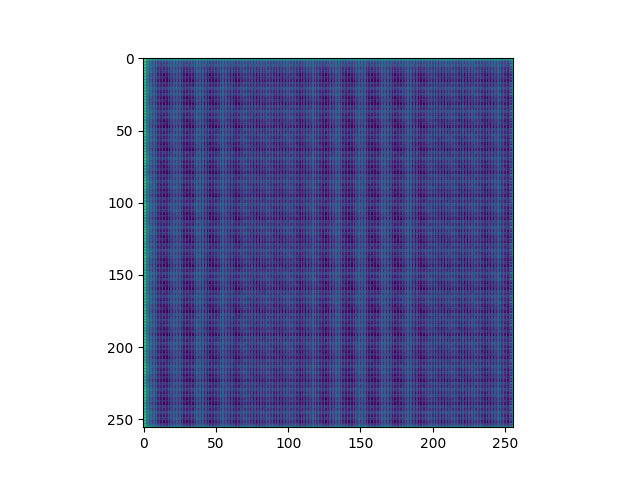

In [189]:
%matplotlib notebook
plt.imshow(reconstructed_img[0,:,:,0])


In [187]:
reconstructed_img[0].shape

(8, 256, 256, 1)